In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import os
from torch.utils.data import Dataset,DataLoader
from torchaudio import transforms as T
from torchaudio.transforms import Resample, MelSpectrogram
from pydub import AudioSegment
import random
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import librosa
import torch.nn.functional as F
from torch.optim import Adam


In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device =torch.device(dev)

In [3]:
device

device(type='cuda', index=0)

In [4]:
dataset_path = "/kaggle/input/language-classification/Langauge Classification Dataset"

In [5]:
class AudioFolderDataset(Dataset):
    def __init__(self, root, transform=None, desired_waveform_length=80000, samples_per_class=2000):
        self.root = root
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(root)
        self.audio_files = self._load_audio_files(samples_per_class)
        self.desired_waveform_length = desired_waveform_length

    def _find_classes(self, dir):
        classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def _load_audio_files(self, samples_per_class):
        audio_files = []
        for class_label in self.classes:
            class_path = os.path.join(self.root, class_label)
            class_files = [filename for filename in os.listdir(class_path) if filename.endswith(".wav") or filename.endswith(".mp3")]
            class_files.sort()  # Ensure consistent order for reproducibility
            class_files = class_files[:samples_per_class]  # Select the first 10000 samples
            for filename in class_files:
                path = os.path.join(class_path, filename)
                audio_files.append((path, self.class_to_idx[class_label]))
        return audio_files

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        path, label = self.audio_files[idx]
        audio = AudioSegment.from_mp3(path)
        wav_path = os.path.join("/kaggle/working/", os.path.basename(path).replace(".mp3", ".wav"))
        audio.export(wav_path, format="wav")
        waveform, sample_rate = torchaudio.load(wav_path)
        os.remove(wav_path)

        if waveform.size(1) < self.desired_waveform_length:
            padding = torch.zeros(1, self.desired_waveform_length - waveform.size(1))
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform.size(1) > self.desired_waveform_length:
            waveform = waveform[:, :self.desired_waveform_length]

        if self.transform:
            waveform = self.transform(waveform)
        return waveform, label


In [6]:

my_transform = T.MFCC()
transform = nn.Sequential(Resample(orig_freq=44100, new_freq=16000), my_transform)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [7]:
dataset = AudioFolderDataset(root=dataset_path, transform=transform)

In [8]:
class_labels = dataset.classes

num_labels = len(class_labels)

print(f"Number of labels: {num_labels}")
print("Class labels:", class_labels)

Number of labels: 4
Class labels: ['Arabic', 'English', 'German', 'Urdu']


In [9]:


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

Waveform shape: torch.Size([1, 40, 146])
Label: 0
Waveform dtype: torch.float32
Class: Arabic


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Figure size 1200x400 with 0 Axes>

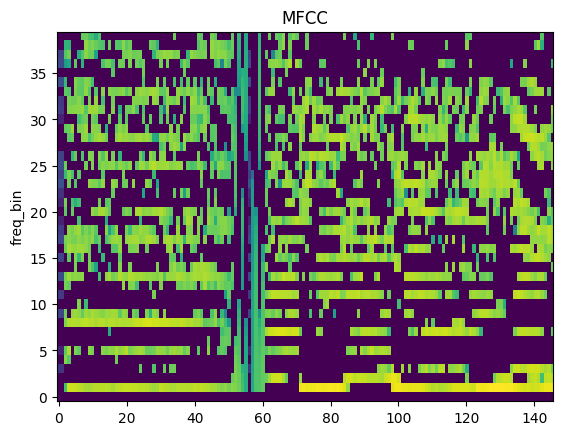

In [10]:
random_idx = random.randint(0, len(dataset) - 1)
waveform, label = dataset[random_idx]
class_name = dataset.classes[label]

print("Waveform shape:", waveform.shape)
print("Label:", label)
print("Waveform dtype:", waveform.dtype)  
print("Class:", class_name)

plt.figure(figsize=(12, 4))
plot_spectrogram(waveform[0], title="MFCC")

In [11]:
class MTFCCNN(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512*2*9, 1024)
        self.fc2 = nn.Linear(1024, 512)        
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, n_classes)                

        
    def forward(self, x):
        x=self.pool1(self.relu(self.conv1(x)))
        x=self.pool2(self.relu(self.conv2(x)))        
        x=self.pool3(self.relu(self.conv3(x)))        
        x=self.pool4(self.relu(self.conv4(x)))
        x=self.conv6(self.relu(self.conv5(x)))
        
        x=self.flatten(x)
        out=self.fc4(self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))))
        
        return out

In [12]:
len(dataset)

8000

In [13]:
train_size=int(0.7*len(dataset))
val_size=int(0.2*len(dataset))
test_size=len(dataset) - train_size - val_size

In [14]:
train_data, val_data, test_data=torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader=DataLoader(train_data, batch_size=64,shuffle=True)
val_loader=DataLoader(val_data, batch_size=32,shuffle=True)
test_loader=DataLoader(test_data, batch_size=64,shuffle=True)

In [15]:
len(train_loader)

88

In [16]:
len(val_loader)

50

In [17]:
len(test_loader)

13

In [18]:
model=MTFCCNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [19]:
next(model.parameters()).device

device(type='cuda', index=0)

In [20]:
# from torch.nn import DataParallel
# model = DataParallel(model)

In [21]:
next(model.parameters()).device

device(type='cuda', index=0)

In [22]:
n_epochs = 15
train_loss_values = []
val_loss_values = []
epoch_count = []
min_valid_loss = np.inf

In [23]:
for epoch in range(n_epochs):
    train_loss = 0.0
    model.train()
    print(f"Epoch: {epoch} ")
    for batch_index, data in enumerate(train_loader):
        x,y = data
        x = x.to(device)
#         print("X ", x.shape)
        y = y.to(device)
        y_hats = model(x)
#         print("Y_hats ", y_hats)
#         print("Y ", y)
        y = F.one_hot(y.long()).float()
#         print("Y one hot", y)
        loss = criterion(y_hats, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0.0
    model.eval()
    for vbatch_index, vdata in enumerate(val_loader):
        vx, vy = vdata
        vx = vx.to(device)
        vy = vy.to(device)
        
        y_preds = model(vx)
        vy = F.one_hot(vy).float()
        vloss = criterion(y_preds, vy)
        val_loss += vloss.item()
        
    print(f"Training Loss: {loss} | Val Loss: {vloss}")
    if epoch % 3 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().cpu().numpy())
        val_loss_values.append(vloss.detach().cpu().numpy())
    if min_valid_loss > val_loss:
        min_valid_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch: 0 
Training Loss: 0.49041813611984253 | Val Loss: 0.48700806498527527
Epoch: 1 
Training Loss: 0.38661035895347595 | Val Loss: 0.33546122908592224
Epoch: 2 
Training Loss: 0.3949395716190338 | Val Loss: 0.3474453389644623
Epoch: 3 
Training Loss: 0.4114522635936737 | Val Loss: 0.2450348436832428
Epoch: 4 
Training Loss: 0.24312248826026917 | Val Loss: 0.12306419014930725
Epoch: 5 
Training Loss: 0.07663138955831528 | Val Loss: 0.24247798323631287
Epoch: 6 
Training Loss: 0.19038285315036774 | Val Loss: 0.10542238503694534
Epoch: 7 
Training Loss: 0.12651821970939636 | Val Loss: 0.14868010580539703
Epoch: 8 
Training Loss: 0.036370933055877686 | Val Loss: 0.4180225133895874
Epoch: 9 
Training Loss: 0.11593957990407944 | Val Loss: 0.5849955081939697
Epoch: 10 
Training Loss: 0.06881695985794067 | Val Loss: 0.1344427466392517
Epoch: 11 
Training Loss: 0.12772448360919952 | Val Loss: 0.15643520653247833
Epoch: 12 
Training Loss: 0.08577315509319305 | Val Loss: 0.13980132341384888
Ep

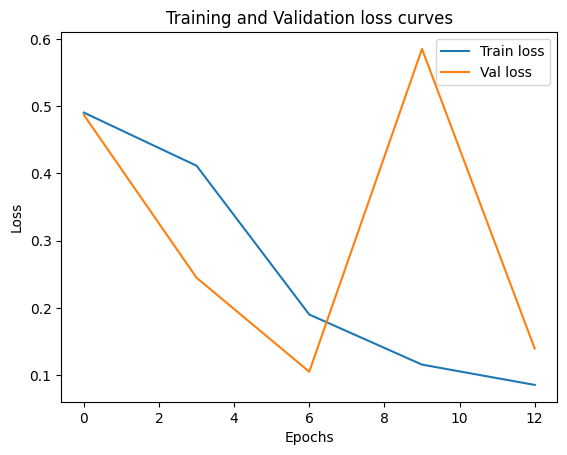

In [24]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, val_loss_values, label="Val loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [25]:
best_model = MTFCCNN()
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

MTFCCNN(
  (relu): ReLU()
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bi

In [26]:
best_model.eval()
correct_predictions = 0.0
total_samples = 0
for batch_index, data in enumerate(test_loader):
    x,y = data
    x = x.to(device)
    y = y.to(device)
    
    y_hats = best_model(x)
    y = F.one_hot(y).float()
    
    _, predicted_labels = y_hats.max(1)
    correct_predictions += (predicted_labels == y.max(1)[1]).sum().item()
    total_samples += y.size(0)
    
test_accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 94.62%


True Label: German
Predicted Label: German


<Figure size 1200x400 with 0 Axes>

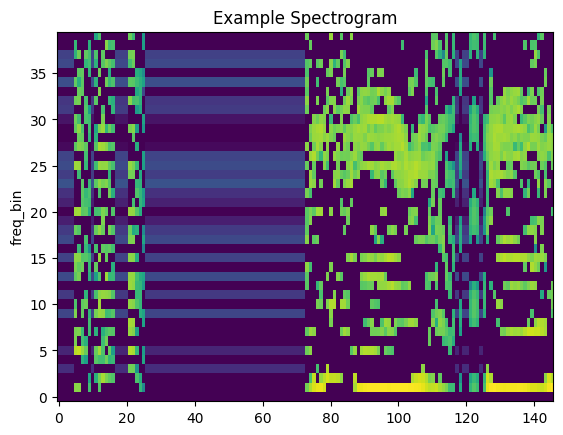

In [27]:
example_idx = 5
example_data, true_label = test_data[example_idx]
example_data = example_data.unsqueeze(0).to(device)  # Add a batch dimension
with torch.no_grad():
    best_model.eval()
    predicted_label = best_model(example_data).argmax(dim=1).item()

class_names = dataset.classes
true_class_name = class_names[true_label]
predicted_class_name = class_names[predicted_label]

print(f"True Label: {true_class_name}")
print(f"Predicted Label: {predicted_class_name}")

plt.figure(figsize=(12, 4))
plot_spectrogram(example_data[0].cpu().squeeze().numpy(), title="Example Spectrogram")
plt.show()

In [28]:
import IPython.display as ipd

waveform_path = "/kaggle/input/german-sample-voice/recorded_audio.wav"
waveform, sample_rate = torchaudio.load(waveform_path)
ipd.Audio(waveform.numpy(), rate=sample_rate)


In [29]:
if waveform.size(1) <80000:
    padding = torch.zeros(1, 80000 - waveform.size(1))
    waveform = torch.cat([waveform, padding], dim=1)
elif waveform.size(1) > 80000:
    waveform = waveform[:, :80000]


torch.Size([1, 40, 146])


<Figure size 1200x400 with 0 Axes>

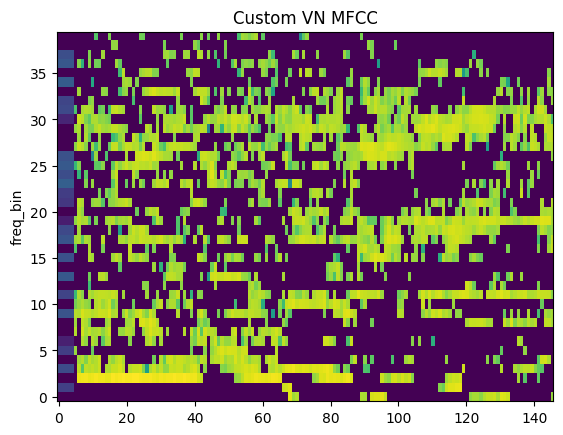

In [30]:
transformed_waveform = transform(waveform)
print(transformed_waveform.shape)
plt.figure(figsize=(12, 4))
plot_spectrogram(transformed_waveform[0], title="Custom VN MFCC")

In [31]:
model_practical = MTFCCNN()  
model_practical.load_state_dict(torch.load('best_model.pth'))
model_pracitcal = model_practical.to(device).eval()

In [32]:
with torch.no_grad():
    model_practical.eval()
    transformed_waveform = transformed_waveform.to(device)
    output = model_practical(transformed_waveform.unsqueeze(0))
    _, predicted_label = output.max(1)

print("Predicted Label:", predicted_label.item())

Predicted Label: 1
